# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

---
## 2. Load data

In [2]:
df = pd.read_csv('client_data.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

The code below was provided to calculate the feature described above. I had to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [4]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [5]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


Inspecionando a feature pré-estabelecida.

In [6]:
#Joining the dataframes
df = df.merge(diff, on='id')

<AxesSubplot: xlabel='offpeak_diff_dec_january_power', ylabel='Density'>

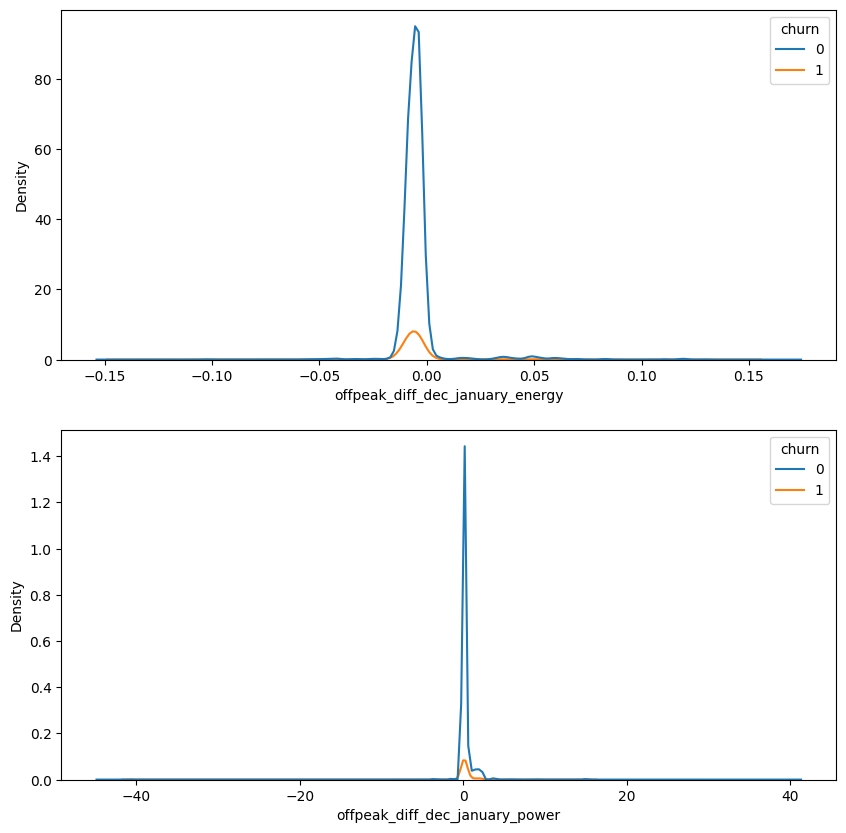

In [7]:
#Plotting KDE plots of power offpeak difference and energy offpeak difference between january and december for churned and non churned customers.
fig, ax = plt.subplots(2, 1, figsize=(10,10))
sns.kdeplot(data=df, x = 'offpeak_diff_dec_january_energy', hue='churn', ax=ax[0])
sns.kdeplot(data=df, x = 'offpeak_diff_dec_january_power', hue='churn', ax=ax[1])

In [8]:
#Verifying if the correlation between the churn and the previously created feature are statistically significant
print(pearsonr(df['churn'], df['offpeak_diff_dec_january_power']))
print(pearsonr(df['churn'], df['offpeak_diff_dec_january_energy']))

PearsonRResult(statistic=0.0026715299322503114, pvalue=0.746815315483335)
PearsonRResult(statistic=-0.0010644314844720326, pvalue=0.8976494793845312)


It's not recomended to use the feature provided, since it has high p-value. We couldn't atest that there's a statistically significant correlation between these features and churn, so it may not be efficient in churn prediction. However, since its use is mandatory for the experience program, i will follow with this feature on the prediction model.

### Percentual difference between last month consumption and mean consumption in the last 12 months

A fase de EDA apontou que existe uma grande diferença no consumo ocorrido entre quem fez churn ou não. Assim, achei proveitoso criar uma feature que analisa a diferença de consumo no último mês, em relação à média do período, esperando que o valor do consumo seja menor entre as pessoas que realizaram churn.

In [9]:
#Creating the new feature 
df['consumption_diff_mean_12m_lastmonth_percent'] = df['cons_last_month']-(df['cons_12m']/12)

<AxesSubplot: xlabel='consumption_diff_mean_12m_lastmonth_percent', ylabel='Density'>

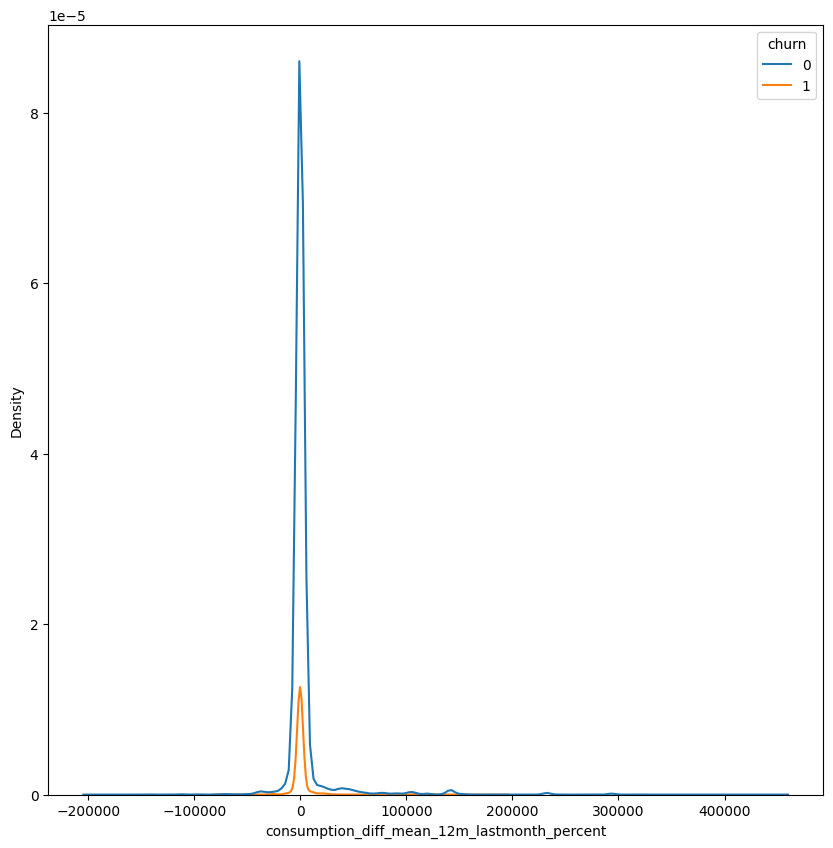

In [10]:
#Plotting KDE plots to inspect the distribution of the feature
fig, ax = plt.subplots(figsize=(10,10))
sns.kdeplot(data=df, x = 'consumption_diff_mean_12m_lastmonth_percent', hue='churn')

The distribution has tails for both sides, the dinamic of the feature is similar for both the churn groups

In [11]:
#Filling NA's with 0
df['consumption_diff_mean_12m_lastmonth_percent'].fillna(0, inplace=True)
df['consumption_diff_mean_12m_lastmonth_percent'].describe()

count     14606.000000
mean       2821.912564
std       21686.353629
min     -194525.250000
25%        -757.375000
50%        -105.125000
75%         496.312500
max      449656.000000
Name: consumption_diff_mean_12m_lastmonth_percent, dtype: float64

In [12]:
#Checking correlation and significance
pearsonr(df['churn'], df['consumption_diff_mean_12m_lastmonth_percent'])

PearsonRResult(statistic=-0.03310565915594221, pvalue=6.287617049842229e-05)

The test indicates that there's a statistically signifcant correlation between the features. It's a negative correlation, which indicates that consuption is lower for the churn group.

### Percentual difference between last 12 months consumption and forecast consumption

Similarly to the feature above, this feature is based on the findings of the EDA phase, atesting that the consumption is lower between churn clients

In [13]:
#Creating the feature
df['diff_12m_forecast'] = df['forecast_cons_12m']/df['cons_12m']

#Since there are 0s on the denomitator, we need to deal with inf numbers
df['diff_12m_forecast'] = df['diff_12m_forecast'].replace([np.inf, -np.inf], 0)
df['diff_12m_forecast'] = df['diff_12m_forecast'].fillna(0)

In [14]:
df['diff_12m_forecast'].describe()

count    14606.000000
mean         0.093119
std          0.055194
min          0.000000
25%          0.042855
50%          0.102308
75%          0.147460
max          0.624622
Name: diff_12m_forecast, dtype: float64

<AxesSubplot: xlabel='diff_12m_forecast', ylabel='Density'>

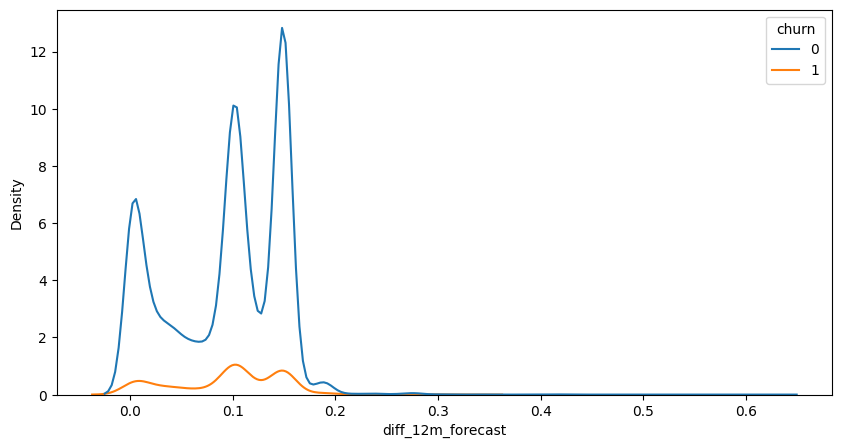

In [15]:
#Plotting KDE plots to inspect the distribution of the feature
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(data=df, x = 'diff_12m_forecast', hue='churn')

The ratio of consumption has peaks around 1%, 10% and 15%, these peaks are higher for non-churn clients

In [16]:
#Checking correlation and significance
pearsonr(df['churn'], df['diff_12m_forecast'])

PearsonRResult(statistic=0.01389992955005203, pvalue=0.09299286346148429)

In this case, the statistical significance of the feature is relatively high (9%), and the correlation indicates that consumption within the churn base is higher than in the non-churn group. Since there's a lot of features in the model and the significance of this feature is somewhat low, we will use it.

### Participation of off-peak power price on total price

Given that the Exploratory Data Analysis (EDA) findings suggest that the off-peak price was crucial for predicting churn, this feature highlights the significance of this type of consumption in the overall bill. It is anticipated that clients with higher off-peak participation are more likely to churn.

In [17]:
#Grouping the data by id and price
monthly_price_by_id = price_df.groupby(['id', 'price_date']).mean().reset_index()

In [18]:
#Evaluating the weight of offpeak price on total bill price
monthly_price_by_id['percent_off_peak_var'] = (monthly_price_by_id['price_off_peak_var']/(monthly_price_by_id['price_off_peak_var']+monthly_price_by_id['price_peak_var']+monthly_price_by_id['price_mid_peak_var']))*100
monthly_price_by_id['percent_off_peak_fix'] = (monthly_price_by_id['price_off_peak_fix']/(monthly_price_by_id['price_off_peak_fix']+monthly_price_by_id['price_peak_fix']+monthly_price_by_id['price_mid_peak_fix']))*100

In [19]:
#Joining the dataframes
df = df.merge(monthly_price_by_id[['id', 'percent_off_peak_var', 'percent_off_peak_fix']], on='id')

#Filling NA's with zeros
df['percent_off_peak_fix'].fillna(0, inplace=True)
df['percent_off_peak_var'].fillna(0, inplace=True)

In [20]:
df[['percent_off_peak_var', 'percent_off_peak_fix']].describe()

,percent_off_peak_var,percent_off_peak_fix
count,175149.000000,175149.000000
mean,72.538129,80.285580
std,27.412829,25.117158
min,0.000000,0.000000
25%,41.622809,50.000000
50%,66.446392,100.000000
75%,100.000000,100.000000
max,100.000000,100.000000


<AxesSubplot: xlabel='percent_off_peak_fix', ylabel='Density'>

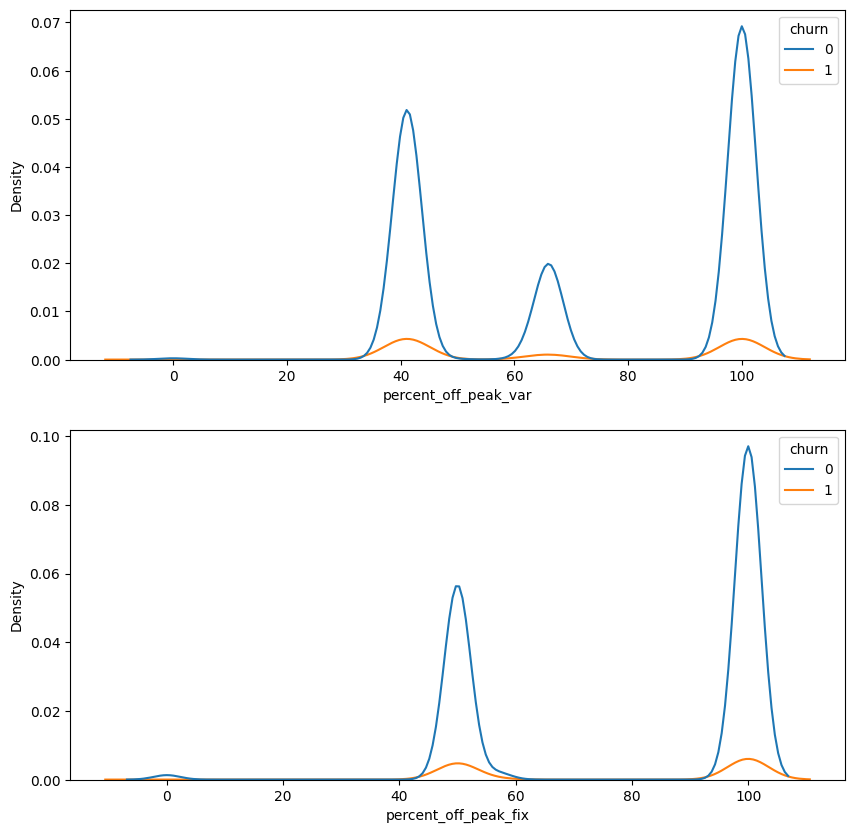

In [21]:
#Plotting KDE plots to inspect the distribution of the features
fig, ax = plt.subplots(2, 1, figsize=(10,10))
sns.kdeplot(data=df, x = 'percent_off_peak_var', hue='churn', ax=ax[0])
sns.kdeplot(data=df, x = 'percent_off_peak_fix', hue='churn', ax=ax[1])

In [22]:
#Checking correlation and significance
print(pearsonr(df['percent_off_peak_var'], df['churn']))
print(pearsonr(df['percent_off_peak_fix'], df['churn']))

PearsonRResult(statistic=-0.033870647332244264, pvalue=1.2340886846445667e-45)
PearsonRResult(statistic=-0.034764430643611774, pvalue=5.549828262152052e-48)


There is a statistically significant correlation between the features; however, the interpretation does not align with what was previously identified in the Exploratory Data Analysis (EDA). We will include this feature in the model because, given the multitude of features influencing the energy price, churn may occur among clients who use less off-peak energy but could be affected by other factors.

### Customer contract duration

From a business perspective, it is reasonable to assume that clients with longer contract durations are less likely to experience churn. This feature examines the contract duration, measured in years, for each client.

In [23]:
#Making the feature 
df['contract_duration'] = df['date_end'] - df['date_activ']
df['contract_duration'] = df['contract_duration'].dt.days
df['contract_duration'] = df['contract_duration']/365

In [24]:
df['contract_duration'].describe()

count    175149.000000
mean          5.500536
std           1.657254
min           2.002740
25%           4.002740
50%           5.010959
75%           6.449315
max          13.136986
Name: contract_duration, dtype: float64

<AxesSubplot: xlabel='contract_duration', ylabel='Density'>

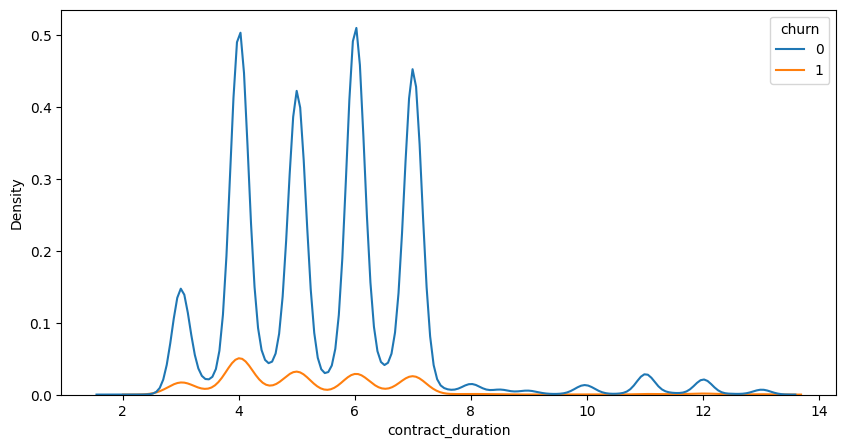

In [25]:
#Plotting KDE plots to inspect the distribution of the features
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(data=df, x = 'contract_duration', hue='churn')

In [26]:
#Checking correlation and significance
print(pearsonr(df['contract_duration'], df['churn']))

PearsonRResult(statistic=-0.07383703963539254, pvalue=3.115230934310429e-210)


As anticipated, there is a correlation between contract duration and churn. Clients with longer contract periods are less likely to experience churn.

# Model and Evaluation

In [50]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, LearningCurveDisplay, ShuffleSplit
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

We gonna use RandomForest algorithm to perform a classification model on our data and try to predict the churn. Since RandomForest works pretty fine with outlier data, few modifications on dataframe are necessary, related to null values and categorical data. We will first encode our categorical data, so it don't throw any error when performing the algorithm; then we will split our model and train it. After the first evaluation, we will cross-validate the model and check feature importance. 

## 1. Data Preparation

In [28]:
#Train_test split
target = 'churn'

X_train, X_test, y_train, y_test = train_test_split(df.drop([target, 'id', 'date_activ', 'date_end', 'date_modif_prod', 'date_renewal'], axis=1), df[target], test_size=0.2, random_state=42)

### 1.1 Missing values handling

In [29]:
#Counting the number of missing values in each column
df.isna().sum()

id                                             0
channel_sales                                  0
cons_12m                                       0
cons_gas_12m                                   0
cons_last_month                                0
date_activ                                     0
date_end                                       0
date_modif_prod                                0
date_renewal                                   0
forecast_cons_12m                              0
forecast_cons_year                             0
forecast_discount_energy                       0
forecast_meter_rent_12m                        0
forecast_price_energy_off_peak                 0
forecast_price_energy_peak                     0
forecast_price_pow_off_peak                    0
has_gas                                        0
imp_cons                                       0
margin_gross_pow_ele                           0
margin_net_pow_ele                             0
nb_prod_act         

Since there's no more null data, it's not necessary to fill it at this point

### 1.2 Dealing with categorical data

In [30]:
#Making a list of categorical data from the variable
cat_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']
cat_columns

['channel_sales', 'has_gas', 'origin_up']

In [31]:
#Using Label Encoder to encode categorical data
le = LabelEncoder()
for col in cat_columns:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

## 2. Initial model evaluation and dataframe modifications

### 2.1. First RFC model fitting

First, we gonna train a model with some set parameters and check it's accuracy, then we can see the most important features and hyperparameter tunning. 

In [32]:
rfc = RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=2)
model = rfc.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [33]:
accuracy_score(y_test, y_pred)

0.9155866400228375

The first model got 91,55% accuracy. 

In [34]:
confusion_matrix(y_test, y_pred)

array([[31705,     0],
       [ 2957,   368]], dtype=int64)

Checking feature importance to understand what are the most important features in the model and remove soma useless features. RandomForestClassifier performance should not be worsened by these features, since its handle very well if this number of variables, but it's a good practice to remove unused features from the model.

<AxesSubplot: >

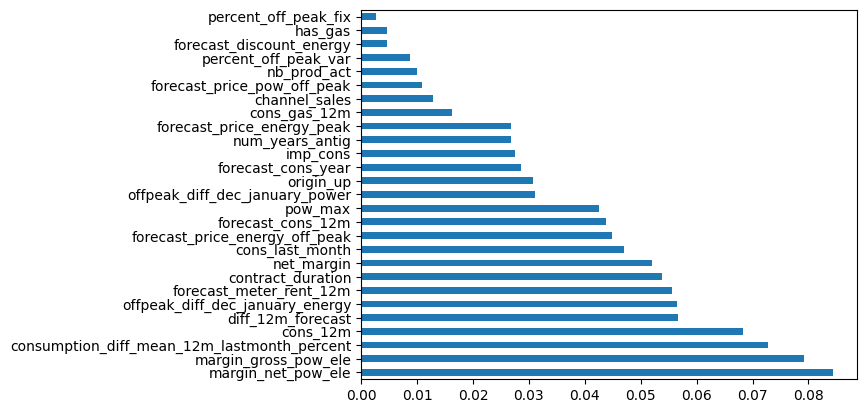

In [35]:
feature_importances = model.feature_importances_
# Associate feature names with their importance scores
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))
# Sort features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(27).plot(kind='barh')

### 2.2. Dataframe modification

The initial model achieved approximately 91.55% accuracy, which is a commendable result. However, there is room for improvement, as an error rate of 9% in certain cases is suboptimal. To enhance the model's performance, we will begin by eliminating certain features. Specifically, we plan to remove features identified as having low impact on churn through Exploratory Data Analysis (EDA). These features include the variable indicating whether the client uses gas, the number of products held by the client, and the channel through which the client received the offer. Additionally, we will exclude any created features that exhibit the lowest importance according to our analysis.

In [36]:
del_features = ['percent_off_peak_fix', 'has_gas', 'percent_off_peak_var', 'nb_prod_act', 'channel_sales']

for col in del_features:
    X_train.drop(col, axis=1, inplace=True)
    X_test.drop(col, axis=1, inplace=True)

### 2.3. Hyperparameter tuning

We will set a range where we RandomSearchCV will work on. It will perform 50 random parameter settings, applying it at 5 folds a time. This work will generate a set of parameters that are almost the best possible.

In [37]:
#Setting some limits for the random_grid to work on and perform a pre-selection of the best parameters.

n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=100)]
max_depth = [int(x) for x in np.linspace(1, 100, 10)]
min_samples_leaf = [5, 10, 20, 40, 100]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
                }

In [38]:
modeL_RSCV = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=50, cv=5, random_state=42) #n_jobs=-1)
modeL_RSCV.fit(X_train, y_train) 

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=10,
                                                    min_samples_leaf=2,
                                                    min_samples_split=5,
                                                    random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': [1, 12, 23, 34, 45, 56, 67,
                                                      78, 89, 100],
                                        'min_samples_leaf': [5, 10, 20, 40,
                                                             100],
                                        'n_estimators': [100, 109, 118, 127,
                                                         136, 145, 154, 163,
                                                         172, 181, 190, 200,
                                                         209, 218, 227, 236,
                                                         245, 254, 263, 272,
                                                         281, 290, 300, 309,
                                                         318, 327, 336, 345,
                                                         354, 363, ...]},
                   random_state=42)

Getting the best parameters for the model

In [39]:
modeL_RSCV.best_params_

{'n_estimators': 936, 'min_samples_leaf': 5, 'max_depth': 67}

### 2.4 Final model tunnel and evaluation

In [44]:
#Fitting a new RandomForestClassifier model, utilizing the best parameters found
rfc = RandomForestClassifier(random_state=42, n_estimators= 936, min_samples_leaf= 5, max_depth= 67)
model = rfc.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [55]:
#Getting performance metrics for the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')

Accuracy: 0.9993434199257779
Precision: 1.0
Recall: 0.9930827067669173


The final model shows good overall performance. It has an accuracy of 99% to detect churning clients. Still, it's interesting to cross validate this model and check if it has overfitting.

### 2.5 Checking for overfitting

We gonna perform cross validation to check wheter there's overfitting on our sample. Cross validation performs model on a set of 10 folds and verify the mean accuracy scores among these folds.

In [47]:
#Performing cross validation to check score, using 10 folds.
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)

In [48]:
#Check mean accuracy score among 10 folds
scores.mean()

0.9996146145152907

the cross validation evaluation shows that there's 99% accuracy on the model across 10 folds, which suggests that there's no overfitting within the sample.

### 2.6 Checking feature importance on the model

<AxesSubplot: >

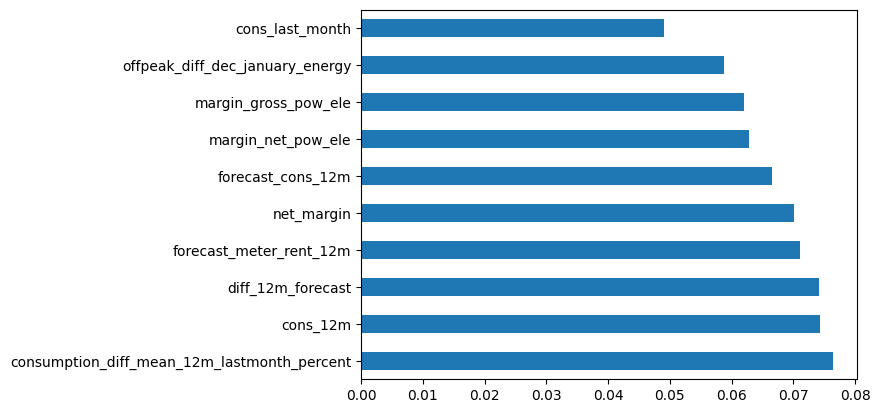

In [54]:
feature_importances = model.feature_importances_

feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))
# Sort features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

# 3. Conclusion

- The final model has a 99% accuracy rate in predicting churning clients.
- PowerCO's price sensitivity hypothesis seems to be inaccurate since the majority of price features don't show a high correlation with churn and appear to be important in detecting churn prevention.
- Consumption features are more definitive in predicting client churn. This aligns with EDA findings, which show a significant difference in consumption between churning and non-churning clients. Last month's consumption is a practical feature to check for churning clients.
- Some created features had high predictive power. Examples include the "Difference in consumption between last month and the mean of the last 12 months," "Difference between forecast consumption and real consumption for 12 months," and "Off-peak power price difference between December and January."